In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import sklearn
import random
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error

In [44]:
filename = 'Dataset/Sensor_Discrimination_normalized.csv'
df=pd.read_csv(filename)
# shuffle the DataFrame rows
df = df.sample(frac = 1) #frac = fraction
dataset=df.iloc[:,:-1]
label=df.iloc[:,-1]
print(dataset)
print(label)

            F2        F3        F1       F11        F4        F6       F10  \
1997  0.280856  0.911171  0.835064  0.195035  0.838517  0.354316  0.206890   
853   0.455615  0.838156  0.647796  0.182092  0.701813  0.218444  0.295369   
679   0.454118  0.853634  0.598433  0.204610  0.731582  0.163084  0.320971   
710   0.299679  0.876178  0.810186  0.179787  0.807584  0.396921  0.200301   
1373  0.513155  0.534320  0.322429  0.232270  0.455347  0.076828  0.256212   
...        ...       ...       ...       ...       ...       ...       ...   
1082  0.107850  0.988392  0.904016  0.945567  0.982538  0.834524  0.931099   
2087  0.131872  0.918405  0.769246  0.244858  0.894229  0.505772  0.435429   
963   0.207850  0.935734  0.928110  0.339894  0.981207  0.744640  0.944654   
937   0.210973  0.965007  0.953575  0.339539  0.991851  0.754535  0.958584   
995   0.533690  0.918573  0.802547  0.177039  0.847830  0.333975  0.262613   

            F9        F5      F7     F12       F8  
1997  0.307

# PCA implement

In [45]:
pcaTrain = PCA(n_components=3).fit(dataset)# --train-- pca with the "dataset" Dataframe
print(pcaTrain)
compressed_dataset_X= pcaTrain.transform(dataset) # --transform-- the original "dataset" Dataframe into a lower-dimensional space based on the model's learned parameters
print(type(compressed_dataset_X))
print(len(compressed_dataset_X[0]))
print(compressed_dataset_X)

PCA(n_components=3)
<class 'numpy.ndarray'>
3
[[-3.72046377 -0.56518984 -0.36982865]
 [ 1.15298669 -0.39749038  0.01994585]
 [ 1.12724726 -0.41607378  0.02594025]
 ...
 [-3.12311424  1.13531314  0.19742205]
 [-2.97823224  1.16904831  0.1836977 ]
 [-3.21460614 -0.36581036 -0.05361463]]


In [46]:
dataset_arr=dataset.to_numpy()
# from NecessaryModules.splitData import split_data
X_train, X_test, y_train, y_test = train_test_split(dataset_arr, label, test_size=0.3, random_state=42)
print(len(X_train))

1548


In [47]:
compressed_dataset_X_train= pcaTrain.transform(X_train) # --transform-- the original "dataset" Dataframe into a lower-dimensional space based on the model's learned parameters
print(type(compressed_dataset_X_train))
print(len(compressed_dataset_X_train))
print(compressed_dataset_X_train)

compressed_dataset_X_test= pcaTrain.transform(X_test) # --transform-- the original "dataset" Dataframe into a lower-dimensional space based on the model's learned parameters
print(type(compressed_dataset_X_test))
print(len(compressed_dataset_X_test))
print(compressed_dataset_X_test)

<class 'numpy.ndarray'>
1548
[[-3.14793566  1.20737344  0.20128812]
 [-3.00231622 -0.22582354 -0.38116981]
 [ 1.24110896  0.55939254 -0.06454041]
 ...
 [ 1.55943694  0.05941938 -0.06331626]
 [-3.21606545  0.97817819  0.09618097]
 [ 1.33974143 -0.6214661  -0.1069403 ]]
<class 'numpy.ndarray'>
664
[[ 1.85316214  0.12312457 -0.18949533]
 [ 1.75402956  1.26985885 -0.05960788]
 [ 1.12862511 -0.57452399  0.00389466]
 ...
 [ 1.73720882  1.14785968 -0.10007573]
 [ 1.64914225 -0.95512785  0.37648856]
 [-3.15544729 -0.18155061 -0.30541257]]


# MLP implement

In [48]:
# train the model with random parameter
from sklearn.neural_network import MLPClassifier

model_MLP = MLPClassifier(
     hidden_layer_sizes=120,
     random_state=42,
     max_iter=300,
     solver="adam"

     
     
     
        
     )

model_MLP.fit(compressed_dataset_X_train, y_train)

MLPClassifier(hidden_layer_sizes=120, max_iter=300, random_state=42)

In [49]:
# Finding mean absolute error
preds = model_MLP.predict(compressed_dataset_X_test)
preds = preds.astype(int)
mae = np.abs(y_test-preds).mean()
mae

0.045180722891566265

In [50]:
#Use Optuna to find the best hyperparameters
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
K = 5 # stratified 5 fold cross validation, The folds are made by preserving the percentage of samples for each class.
skf = StratifiedKFold(n_splits = K, random_state = 42, shuffle = True)

train_tunned= np.array(compressed_dataset_X)
target_train_tunned= np.array(label)

oof_preds= np.zeros((len(train_tunned)))
abs_error_arr=[]
def objective_MLP(trial):

 for train_index, val_index in (skf.split(compressed_dataset_X,label)):
    train_X, valid_X = train_tunned[train_index], train_tunned[val_index]
    train_Y, valid_Y = target_train_tunned[train_index], target_train_tunned[val_index]
    param={
        'hidden_layer_sizes':trial.suggest_int("hidden_layer_sizes", 150, 500),
        # solver=trial.suggest_categorical("solver", ["lbfgs", "sgd", "adam"]),
        'learning_rate':trial.suggest_categorical("learning_rate", ["constant", "invscaling", "adaptive"]),
        'random_state':trial.suggest_int("random_state",0, 10),
        'max_iter':trial.suggest_int("max_iter",100,1000),
        'activation':trial.suggest_categorical("activation", ["logistic", "tanh", "relu"]),
        'batch_size':trial.suggest_int("batch_size",2,20),
        'verbose':False
    }
    model=MLPClassifier(**param)
    model.fit(train_X, train_Y)
    preds = model.predict(valid_X)
    oof_preds[val_index] = preds # preds gives total 3846 predicted value for valid_X
 mae = mean_absolute_error(target_train_tunned, oof_preds)
 return mae

In [51]:
# this is the main optuna for optimizing a object-->"objective"
study_MLP = optuna.create_study(direction='minimize',study_name="MLP_tunning")

[I 2024-02-12 12:04:17,481] A new study created in memory with name: MLP_tunning


In [52]:

study_MLP.optimize(objective_MLP, n_trials=5) 
print('Number of finished trials:', len(study_MLP.trials))
print('Best trial:', study_MLP.best_trial.params)

[I 2024-02-12 12:05:38,640] Trial 0 finished with value: 0.08227848101265822 and parameters: {'hidden_layer_sizes': 447, 'learning_rate': 'adaptive', 'random_state': 1, 'max_iter': 142, 'activation': 'logistic', 'batch_size': 5}. Best is trial 0 with value: 0.08227848101265822.
[I 2024-02-12 12:06:04,764] Trial 1 finished with value: 0.05877034358047016 and parameters: {'hidden_layer_sizes': 301, 'learning_rate': 'invscaling', 'random_state': 3, 'max_iter': 251, 'activation': 'relu', 'batch_size': 20}. Best is trial 1 with value: 0.05877034358047016.
[I 2024-02-12 12:07:31,200] Trial 2 finished with value: 0.081374321880651 and parameters: {'hidden_layer_sizes': 394, 'learning_rate': 'constant', 'random_state': 1, 'max_iter': 961, 'activation': 'logistic', 'batch_size': 5}. Best is trial 1 with value: 0.05877034358047016.
[I 2024-02-12 12:08:05,221] Trial 3 finished with value: 0.06645569620253164 and parameters: {'hidden_layer_sizes': 362, 'learning_rate': 'constant', 'random_state': 

Number of finished trials: 5
Best trial: {'hidden_layer_sizes': 301, 'learning_rate': 'invscaling', 'random_state': 3, 'max_iter': 251, 'activation': 'relu', 'batch_size': 20}


In [53]:
#evaluate the trial
print("Number of finished trials: ", len(study_MLP.trials))
print("Best trial:")
trial = study_MLP.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  5
Best trial:
  Value:  0.05877034358047016
  Params: 
    hidden_layer_sizes: 301
    learning_rate: invscaling
    random_state: 3
    max_iter: 251
    activation: relu
    batch_size: 20


In [54]:
# import pickle
# model_tuned=MLPClassifier(**study_MLP.best_trial.params, verbose=False)
# pickle.dump(model_tuned, open("all_pkl_file/all_tuned_model/PLC_MLP.pkl", "wb"))

In [55]:
from matplotlib import pyplot as plt
fig_study = optuna.visualization.plot_parallel_coordinate(study_MLP, params=["hidden_layer_sizes", "learning_rate","random_state","max_iter","batch_size"])
fig_study.show()

# fit tuned MLP

In [56]:
# Let us make predictions for each of the 5 models and find mean 
# of those predictions

K2 = 10 # stratified 5 fold cross validation, The folds are made by preserving the percentage of samples for each class.
skf2 = StratifiedKFold(n_splits = K2, random_state = 42, shuffle = True)

from tqdm import tqdm
train_MLP = np.array(compressed_dataset_X_train)
target_train_MLP= np.array(y_train)

test_MLP = np.array(compressed_dataset_X_test) # or test_Ada = np.array(X)


test_preds_MLP = np.zeros((len(test_MLP)))
oof_preds_MLP = np.zeros((len(train_MLP)))

for train_index, val_index in tqdm(skf2.split(compressed_dataset_X_train,y_train), total=10):
    train_X, valid_X = train_MLP[train_index], train_MLP[val_index]
    train_y, valid_y = target_train_MLP[train_index], target_train_MLP[val_index]
    ada_params = study_MLP.best_trial.params
    model_MLP_2 = MLPClassifier(**ada_params,tol=.00001,early_stopping=True) # for early_stopping
    model_MLP_2.fit(train_X, train_y)
    # for train accuracy
    preds = model_MLP_2.predict(valid_X)
    oof_preds_MLP[val_index] = preds
    # for test accuracy
    preds = model_MLP_2.predict(test_MLP)
    test_preds_MLP += (preds)/10
print(np.abs(oof_preds_MLP-target_train_MLP).mean())

100%|██████████| 10/10 [00:07<00:00,  1.41it/s]

0.082687338501292


In [57]:
target_test_MLP = np.array(y_test)

In [58]:
from sklearn.metrics import accuracy_score
valid_Acc_MLP=accuracy_score(target_train_MLP,oof_preds_MLP)
print(valid_Acc_MLP)

# another technique for calculate test accuracy
test_Acc_MLP=accuracy_score(target_test_MLP,test_preds_MLP.round())
print(test_Acc_MLP)

0.9295865633074936
0.9457831325301205


In [59]:
train_Acc_MLP=model_MLP_2.score(compressed_dataset_X_train,y_train)
print(train_Acc_MLP)

0.9347545219638242


In [60]:
test_Acc_MLP=model_MLP_2.score(compressed_dataset_X_test,y_test)
print(test_Acc_MLP)

0.9518072289156626


# Evaluation

**confusion-matrix**

In [61]:
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, test_preds_MLP.round())
cm

array([[259,   9,   1],
       [ 20, 225,   0],
       [  3,   3, 144]], dtype=int64)

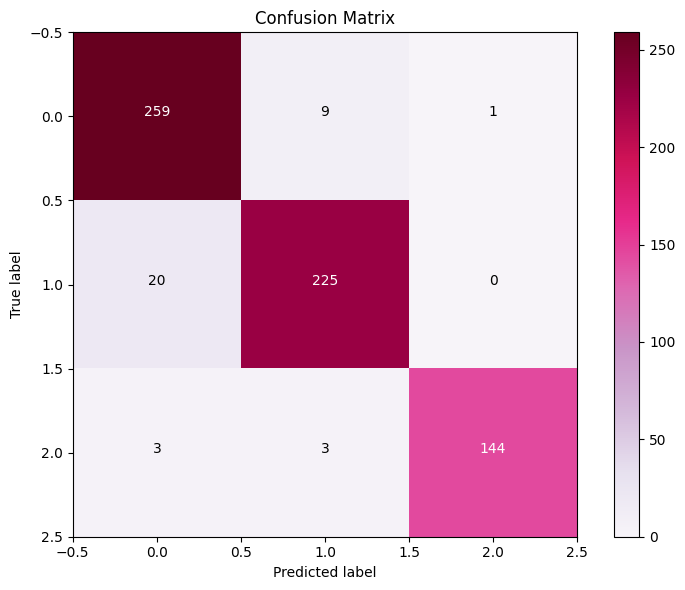

In [62]:
############# plot confusion matrix ############

from matplotlib import pyplot as plt
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, test_preds_MLP.round())
# Plot confusion matrix with custom color map

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.PuRd)  # Set cmap to custom color map
plt.title('Confusion Matrix')
plt.colorbar()

# Adding annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), #'d = integer
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout() #improves the layout of plots by preventing overlapping elements such as axis labels, tick labels, and titles
plt.show()


**train-loss**

In [63]:
# find the losses at each iteration
# train_losses=classifier.fit(compressedDataframeTrain, y_train).loss_curve_
train_losses=tunned_model.loss_curve_

NameError: name 'tunned_model' is not defined

In [ ]:
print(train_losses)
print(len(train_losses)) #384= converge at iteration 276 from max_iter 571


[1.018139743537125, 0.8398871491080491, 0.8004493668712055, 0.7699043716983041, 0.74373603839393, 0.7223123896814918, 0.7034758544257165, 0.6875908901532551, 0.6730110081992331, 0.6597644072340302, 0.6498510837060442, 0.6396747504982417, 0.6307251920120416, 0.621461270171723, 0.6130047117292743, 0.606765568488888, 0.6000990003211314, 0.5941293542425539, 0.586832667412677, 0.5799253685119561, 0.5758682631351955, 0.5703895671840727, 0.5654980496494396, 0.5602678580860742, 0.5549991189588401, 0.5508883969698828, 0.5440615147619842, 0.5415185215222991, 0.5369356630632617, 0.5326530738396661, 0.5293006639903006, 0.5249154599920377, 0.5205289113202317, 0.5176135720909906, 0.5147527427496812, 0.5116111498297335, 0.5069445391199633, 0.5026096372064954, 0.5015295502971607, 0.4965197035024674, 0.4928550295216376, 0.4887826864287143, 0.4866336596561266, 0.4854697070747538, 0.48181460233968854, 0.4798024830495578, 0.47592543129886633, 0.4738788513457339, 0.47091748945397016, 0.4695801956636619, 0.

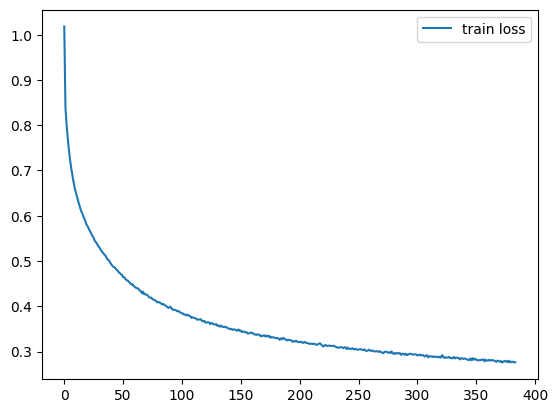

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(len(train_losses)), train_losses, label="train loss")

plt.legend()


**validation graph**

**Learning_curve********

In [ ]:

compressed_dataset_X.shape

(19229, 30)

In [ ]:
y.shape

(19229,)

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.neural_network import MLPClassifier
################# it will take 0.8 as train data from the whole by-default ################
mlp = MLPClassifier(batch_size=11, hidden_layer_sizes=212, learning_rate='adaptive',random_state=5,max_iter=1000) #tuned MLP
train_sizes, train_scores, test_scores = learning_curve(mlp, compressed_dataset_X, y, train_sizes=np.linspace(0.1, 1.0, 5))

In [ ]:
train_sizes

array([ 1538,  4999,  8460, 11921, 15383])

In [ ]:
train_scores # by-default 5-fold cross validation

array([[0.99024707, 0.98114434, 0.98114434, 0.98114434, 0.98114434],
       [0.95639128, 0.93438688, 0.94238848, 0.94238848, 0.94238848],
       [0.92174941, 0.90425532, 0.90484634, 0.92080378, 0.92080378],
       [0.91066186, 0.90202164, 0.90621592, 0.92072813, 0.91544334],
       [0.89221868, 0.89462394, 0.90561009, 0.89676916, 0.91302087]])

In [ ]:
test_scores

array([[0.67524701, 0.68720749, 0.68720749, 0.67160686, 0.67906372],
       [0.77769111, 0.7698908 , 0.76729069, 0.76859074, 0.76644993],
       [0.80655226, 0.79875195, 0.79303172, 0.79979199, 0.79141743],
       [0.8174727 , 0.81877275, 0.81929277, 0.8200728 , 0.82158648],
       [0.825013  , 0.8276131 , 0.83619345, 0.82371295, 0.8319896 ]])

In [ ]:
#***** Calculate mean and standard deviation of train and test scores (as we got values for 5 fold cross in each row****)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

In [ ]:
train_mean

array([0.98296489, 0.94358872, 0.91449173, 0.91101418, 0.90044855])

In [ ]:
train_std

array([0.00364109, 0.00711198, 0.0081262 , 0.0066029 , 0.00774467])

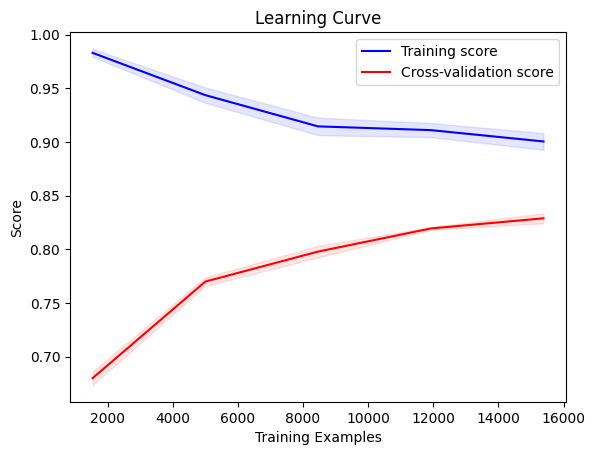

In [ ]:
# Plot learning curves
plt.figure()
plt.plot(train_sizes, train_mean, label='Training score', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1) #alpha=0.1: The transparency of the shaded region.
plt.plot(train_sizes, test_mean, label='Cross-validation score', color='red')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='red', alpha=0.1)
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

**ROC_curve*******

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [ ]:
# Binarize the output
y_train = label_binarize(y_train,classes=[0,1,2,3,4,5,6])
n_classes = y_train.shape[1]
print(n_classes)
print(y_train[0])

7
[0 0 1 0 0 0 0]


In [ ]:
# Binarize the output (y_test)
y_test = label_binarize(y_test,classes=[0,1,2,3,4,5,6])
n_classes = y_test.shape[1]
print(n_classes)
print(y_test[0])

7
[1 0 0 0 0 0 0]


In [ ]:
# Learn to predict each class against the other
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(batch_size=11, hidden_layer_sizes=212, learning_rate='adaptive',random_state=5,max_iter=500) #tuned MLP
classifier = OneVsRestClassifier(clf)

# Train the classifier
classifier.fit(compressed_dataset_X_train, y_train)

OneVsRestClassifier(estimator=MLPClassifier(batch_size=11,
                                            hidden_layer_sizes=212,
                                            learning_rate='adaptive',
                                            max_iter=500, random_state=5))

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict() #dictionary
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], classifier.predict_proba(compressed_dataset_X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

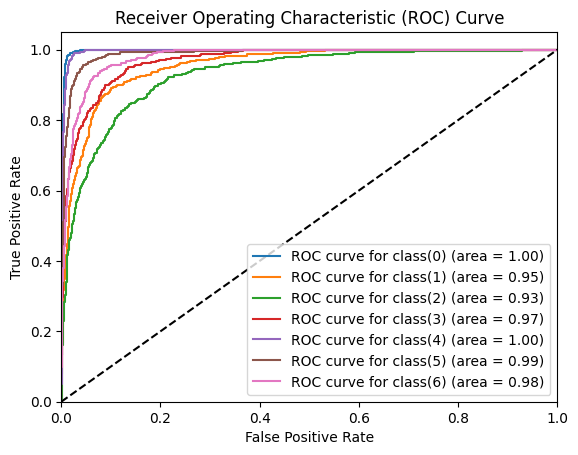

In [ ]:
# Plot ROC curve for each class
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve for class(%i) (area = %0.2f)' % (i,roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="best")
plt.show()

# MLP with validation and early stopping

In [ ]:
from sklearn.neural_network import MLPClassifier



model=MLPClassifier(batch_size=11, hidden_layer_sizes=212, learning_rate='adaptive',
              max_iter=571, random_state=5,early_stopping=True,tol=0.0001,n_iter_no_change=10) #tuned MLP
print(model)


train_acc = model.fit(compressed_dataset_X_train, y_train).score(compressed_dataset_X_train, y_train)

test_acc=model.score(compressed_dataset_X_test,y_test)


print('train accuracy: {} \t test accuracy: {}'.format(train_acc,test_acc))



MLPClassifier(batch_size=11, early_stopping=True, hidden_layer_sizes=212,
              learning_rate='adaptive', max_iter=571, random_state=5)
train accuracy: 0.8461086828886425 	 test accuracy: 0.8105128205128205


In [ ]:
train_losses_ES=model.loss_curve_
print(len(train_losses_ES)) # converse at 329 but trining stop at 68th iteration as the validation loss increases

67


In [ ]:
validation_score_ES=model.validation_scores_
print(len(validation_score_ES))

67


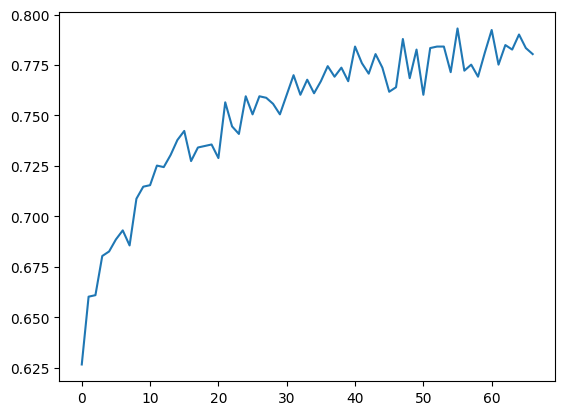

In [ ]:
plt.plot(range(len(validation_score_ES)), validation_score_ES, label="validation acc")

# with pre-tuned MLP

In [ ]:
# import torch
# from NecessaryModules.convert2Tensor import convert2Tensor
# from sklearn.neural_network import MLPClassifier

# # classifier =pickle.load(open("Classifier/MLP_model.pkl", "rb"))
# classifier=MLPClassifier(activation='tanh', batch_size=18, hidden_layer_sizes=158,
#               learning_rate='adaptive', max_iter=910, random_state=3,
#               solver='lbfgs')
# print(classifier)

# epoch=20
# train_A=[]
# valid_A=[]



# for i in (1,epoch):
#     train_acc = classifier.fit(compressedDataframeTrain, y_train).score(compressedDataframeTrain, y_train)
#     valid_acc=classifier.score(compressedDataframeValid,y_val)
    
#     train_A.append(train_acc)
#     valid_A.append(valid_acc)
#     # test_acc=classifier.fit(compressedDataframeTest, y_train).score(compressedDataframeTest,y_test)
#     # test_A.append(test_acc)

# # print('train accuracy: {} '.format(np.max(train_A)))
# print(train_A)
# print(valid_A)



In [ ]:
# test_A=[]
# for i in (1,epoch):
#     test_acc=classifier.score(compressedDataframeTest,y_test)
#     test_A.append(test_acc)
# #
# print('test accuracy: {} '.format(np.max(test_A)))